In [8]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
''')

회귀 머신러닝 모델을 이용한 등급컷 추정 방법
======
## 목차  

### 1. 분석 목적   
### 2. 기초 변수 탐색
    - DB 내 데이터 추출 이후 처리
    - 전처리 이후 집계 데이터  
### 3. 머신러닝 모델링  
    - 회귀모형
    - Stacking 모형
### 4. 결론


In [2]:
import pandas as pd 
import numpy as np
import time 
import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import seaborn as sns
import pickle

import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_name = fm.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
mpl.rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False

pd.set_option('mode.chained_assignment', None)

        
import warnings

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points        

### 1. 분석 목적
수능 등급컷은 해당 시험의 난이도를 평가하는데 가장 흔하게 사용되는 지표이며 평가원에서 발표하는 확정 성적 발표 이전, 수시와 정시 대학입시 전략 수립에 있어 가장 참고 할 만한 자료이다.   

![참조][logo]

[logo]: https://post-phinf.pstatic.net/MjAxOTA4MjhfMTI1/MDAxNTY2OTY4MTc0Mjg1.MXMmgEz-sVCX2-IkaT9DlL8mRFyfcGV7exSjkeKtwU8g.z1vRAVozXtcwfsFi4RDKvKMs498qRxwUt_jWvKwF0-0g.JPEG/1_%EB%93%B1%EA%B8%89_%EB%B0%B1%EB%B6%84%EC%9C%84_%EA%B8%B0%EC%A4%80%ED%91%9C.jpg?type=w1200   

학원에서는 해당 시험의 등급컷을 추정하는데 있어서 고정된 학원생 데이터 세트를 이용한 비추정 방식의 추정방법을 이용하여 등급컷을 추정하지만 온라인 서비스에서는 아래와 같은 이유로 인하여 비추정보다 고도화된 추정방법이 필요하다.   
- 자사 혹은 타사의 이벤트의 유무로 인해 끊임없이 변화하는 회원 풀
- 중상위권에 편향된 회원 성적 분포
- 가짜성적을 상당수의 입력하는 회원  
   
메가스터디는 오래 전 부터 해당 문제를 인지하고 과거 회원 성적을 이용한 bootstrap resampling과 몬테카를로 시뮬레이션을 결합한 시뮬레이션을 이용하여 등급컷을 추정했으며 오랜 기간 신뢰도 높은 등급컷을 서비스하며 많은 이용자를 모을 수 있었다.
하지만 2019학년도 부터 본격적으로 판매하기 시작한 수강 프리패스 상품인 메가패스를 판매하기 시작하면서 최상위권 이용자가 몰리면서 성적 편향 현상이 심화되었고 등급컷 추정 프로세스에 보완이 필요성이 높아졌다.
    
이번 분석의 목적은 위에서 언급한 문제를 해결하여 등급컷 정확도를 높이고 정시 합격예측서비스에 기초데이터인 표준점수 및 백분위 데이터 정확도를 함께 제고시켜 모의고사 풀서비스 및 합격예측서비스 이용자 수를 높이는 것을 가장 큰 목표로 삼고 있다.


![참조][logo2]

[logo2]: https://image.chosun.com/sitedata/image/200904/01/2009040101189_5.jpg

   
현재 분석에서는 주요과목인 국어, 수학 가, 수학 나 과목에 한해서만 분석한다.   
(2019학년도 부터 영어는 절대평가로 전환)

### 2. 기초 변수 탐색

##### - DB 내 데이터 추출

**아래 쿼리를 이용하여 DB 내에서 데이터를 추출한다.**



In [3]:
with open('tmp.p', 'rb') as f:
    dataset = pickle.load(f) # 단 한줄씩 읽어옴

dataset = dataset.reset_index(drop=True)
dataset.brth = dataset.brth.fillna(0)

def get_age(x):
    try:
        brth = x['brth']
        if brth!=0:
            if brth[0]=='0':
                year = int('20'+str(brth[:2]))
            else:
                year = int('19'+str(brth[:2]))
            if int(brth[2:])<=2:
                year-=1
            return int(x['yr']) - year + 1         
        else:
            return 19
    except:
        return 19
    
dataset['age'] = dataset.apply(lambda x: get_age(x), axis=1)
dataset = dataset.query("19<=age<=21")

In [4]:
dataset.head()

,seq,id,sub_cod,score,grade,tot_per,yr,mth,brth,ans_dt,grade_cut_score,gap,exam_dt,dt_gap,age
0,247,1703,1003,95,1,0.276,2019,3,9910,2019-03-07 18:23:29.370,82,13,2019-03-07,18,21
1,247,1703,2004,88,2,7.012,2019,3,9910,2019-03-07 18:24:17.480,82,6,2019-03-07,18,21
2,247,254694,1003,100,1,0.026,2019,3,0110,2019-03-07 18:23:29.370,82,18,2019-03-07,18,19
3,247,77799,1003,53,4,39.784,2019,3,0104,2019-03-07 18:23:29.370,52,1,2019-03-07,18,19
4,247,77799,2004,74,3,21.017,2019,3,0104,2019-03-07 18:24:17.480,73,1,2019-03-07,18,19


### 데이터 정보

| 칼럼 | 칼럼명 | 비고 |
|---|:---:|:---:|
| `seq` | 차수 | 모든 모의고사는 차수를 붙여 관리함 |
| `sub_cod` | 과목코드 |  1003: 국어, 2004: 수학가 2005: 수학나|
| `score` | 해당 시험 원점수 |  |
| `grade` |  해당 시험 등급|  |
| `tot_per` |  해당 원점수의 누적비율| 사용안함 |
| `yr` |  해당 시험 년도|  |
| `mth` |  해당 시험 월|  |
| `brth` |  회원생년월일| 당시 시험기준 현역~삼수까지만 데이터 사용 |
| `grade_cut_score` |  해당 차수 등급컷|  |
| `gap` |  해당 차수 등급컷과 원점수 차이|  |
| `dt_gap` |  시험 당일 00시 기준 채점시간 차이 | 시간단위, 48시간 이후에 채점한 이용 사용 안함 |



### 현역, 재수, 삼수생 별 전체 데이터 분포
채점서비스를 이용한 회원 중 생년월일을 입력하지 않은 회원이 다수 확인됨.  
해당 결측값을 대체하기 위해서 회원의 나이에 대한 분포를 아래 plot을 통해 확인한 결과,   
현역 학생의 비율이 압도적으로 많은 것으로 확인하여 생년월일이 불명인 경우 현역으로 대체하기로 함

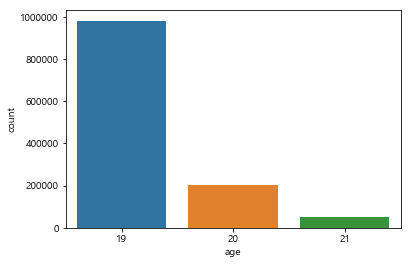

In [5]:
sns.countplot(x = 'age',data = dataset)

In [6]:
seq = dataset[['seq','mth','yr']].drop_duplicates()
seq_major = sorted(seq[seq['mth'].isin([4,6,9,11])].seq.tolist())
seq_minor = sorted(seq[seq['mth'].isin([3,4,7,10,11])].seq.tolist())

In [7]:
def get_old_seq(x,seq_major,seq_minor):
    mth = x['mth']
    x = x['seq']
    try:
        if int(mth) in [6,9,11] :
            li = seq_major
        else:
            li = seq_minor
        if (li.index(int(x))-1) >= 0:
            return li[li.index(int(x))-1]
        else:
            return 0
    except Exception as e:
        return 0

dataset['old_seq'] = dataset.apply(lambda x: get_old_seq(x,seq_major,seq_minor),axis=1)

In [8]:
with open('tmp2.p', 'rb') as f:
    df_grdcut = pickle.load(f) # 단 한줄씩 읽어옴

Text(0, 0.5, '원점수')

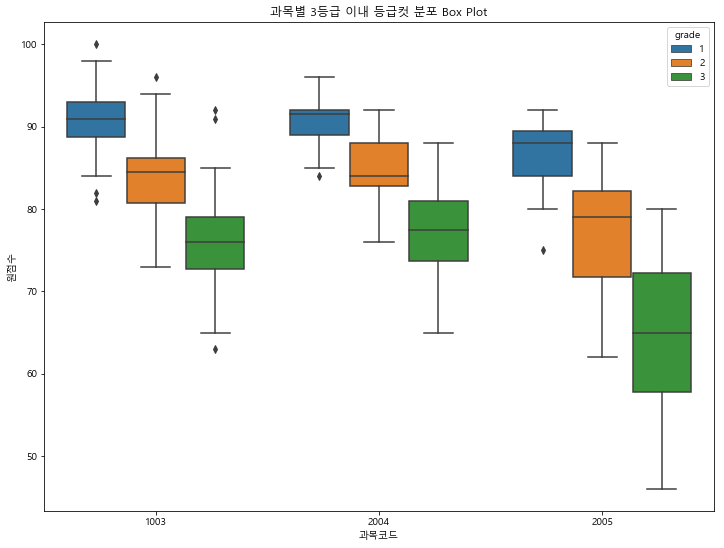

In [78]:
plt.subplots(figsize=(12,9))
sns.boxplot(y='grade_cut_score',x='sub_cod',hue='grade',data=df_grdcut.query("grade<=3"))
plt.title("과목별 3등급 이내 등급컷 분포 Box Plot")
plt.xlabel('과목코드')
plt.ylabel('원점수')

In [10]:
dataset2 = dataset[['seq','sub_cod','id','score','grade','tot_per','grade_cut_score','gap']].copy(deep=True)
dataset2.columns=['old_seq','sub_cod','id','old_score','old_grade','old_tot_per','old_cut','old_gap']
dataset = pd.merge(dataset, dataset2, how='left',left_on=['old_seq','sub_cod','id'],right_on=['old_seq','sub_cod','id'])


### 2019년 기준 이전 시험의 등급에 따른 월별 접수 인원(6등급 이내 기준)
2019년에 있었던 모의고사 기준으로 3월의 경우 작년 수능에 응시한 재수생을 기준으로 매칭했지만 그 수가 굉장히 작은 것으로 확인된다.
3, 4, 7, 10월의 경우 이전에 1등급인 회원이 2등급인 회원보다 많은 것을 확인 가능하며 경우에 따라서는 3등급 회원보다 수가 많은 것을 확인 할 수 있었다. 이는 실제 분포와는 달리 최상위권에 편향된 분포를 가지고 있다는 점을 나타낸다.   
   
6월의 경우 이전에 평가원 출제 모의고사가 없어 4월 회원 분포를 통해 데이터를 매칭한 관계로 3, 4, 7, 10월의 데이터와 유사한 분포를 보이고 있지만 9월과 11월의 경우 이전과 상당히 다른 분포를 가지고 있는 것을 확인 할 수 있다.
수능의 경우 유독 2등급 데이터가 많은 것을 확인 할 수 있는데 이는 반수생의 유입으로 인한 증가로 추정된다.
이는 월별 회원 나이 별 분포 plot을 그려 확인 할 예정이다.

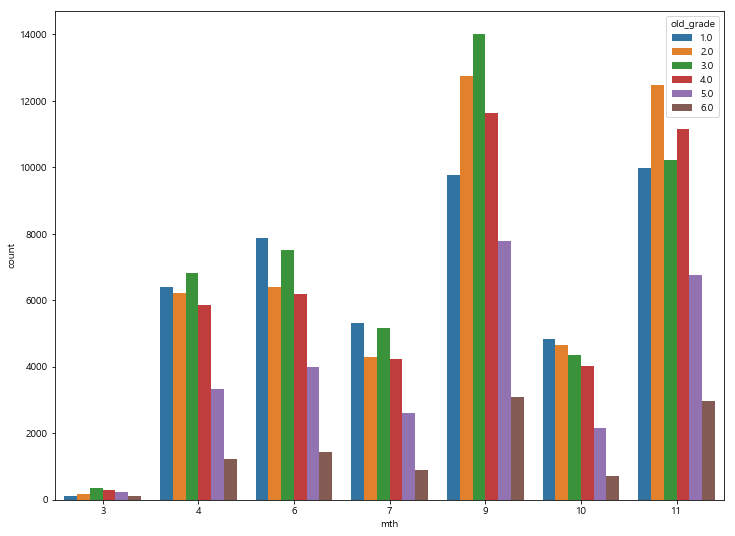

In [11]:
plt.subplots(figsize=(12,9))
sns.countplot(x = 'mth',data = dataset.query("(old_grade<=6) & (yr==2019)"),hue='old_grade')


### 2019년 데이터 기준 월별 응시생 나이 별 count plot
위의 plot에서는 월 마다 이전 시험에서 받은 등급에 따라 얼마나 많은 회원이 들어왔는지 확인하였다.
11월의 경우 반수생의 유입이 증가한 것으로 추정되는 관계로 월에 따른 나이 별 회원 분포를 확인하고자 한다.

아래 plot을 통해 확인한 결과 11월의 경우 반수생의 증가세로 인해 재수생의 인원이 증가 할 것으로 예상했지만 크게 늘지 않았다.
하지만 현역 회원의 유입이 감소한 것으로 보이는 데 이는 수시 합격으로 인하여 현역 회원의 정시 응시인원이 크게 감소하여 발생한 문제로 보인다. 반수생 증가의 경우 11월이 아닌 9월에서 발생한 것으로 보인다.  


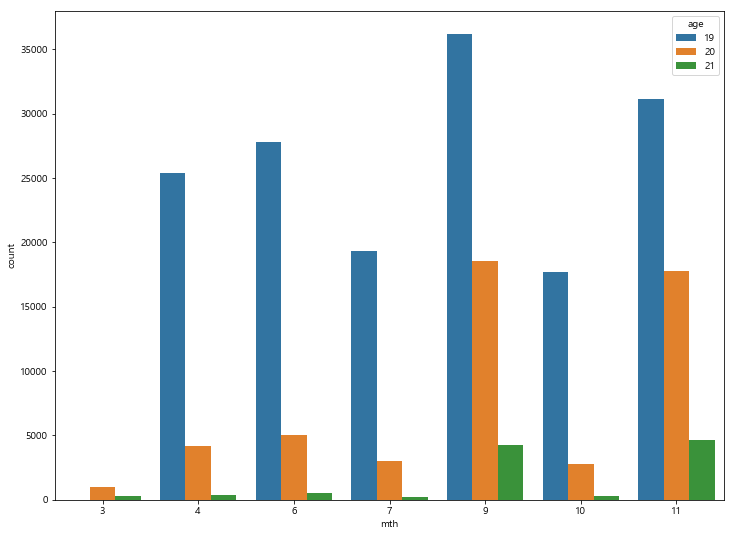

In [12]:
plt.subplots(figsize=(12,9))
sns.countplot(x = 'mth',data = dataset.query("(old_grade<=6) & (yr==2019)"),hue='age')


In [13]:
with open('tmp3.p', 'rb') as f:
    data_mth = pickle.load(f) # 단 한줄씩 읽어옴

### 이전 시험 매칭 이후 채점시간 칼럼 dt_gap 칼럼을 채점 시간에 따라 케이스를 나눈 후 케이스에 따라 변수 변환한다.
| dt_bin | 케이스 
|---|:---:
| `1` | 당일 18시 이전 |
| `2` | 당일 19시 이전 |
| `3` | 당일 20시 이전 |
| `4` | 당일 21시 이전 |
| `5` | 당일 22시 이전 |
| `6` |  시험당일 24시간 이내 |
| `7` |  시험당일 48시 이내 |


In [14]:
dataset=dataset.query("dt_gap>=8") #서비스 오픈 이전 비정상 데이터 삭제
bins = [0, 18, 19, 20, 21, 22, 24, 100]
labels=[1,2,3,4,5,6,7]
#6시 이전, 7시, 8시, 9시, 10시, 12시, d+1일, d+2일

cat = pd.cut(dataset['dt_gap'], bins=bins,labels=labels)

dataset['dt_bin']=cat


### 이전에 응시한 시험에 대한 회원 정보를 데이터에 매칭 
각 시험 차수 및 원점수, 등급 등 정보는 칼럼 앞에 old를 붙여 관리한다. (old_seq, old_score, old_grade,	old_tot_per, old_cut, old_gap)
등급컷에 해당하는 원점수를 추장할 때, 이전 차수의 성적을 매칭하여 추정하면 유의할 것으로 판단하여 아래의 heatmap을 통해 각 월 별 데이터에 매칭할 시험을 매칭완료함.

- 월별 시험 매칭 정보

| 월 | 매칭|corr|
|---|:---:|:---:|
| `3` | 작년 수능 |없음|
| `4` | 3월 |0.43|
| `6` | 4월 |0.51|
| `7` |  4월|0.51|
| `9` |  6월 |0.60|
| `10` |  7월 |0.57|
| `11` |  9월 |0.58|


### 아래는 2019학년도 회원 백분위 기준 모의고사 성적 Heatmap

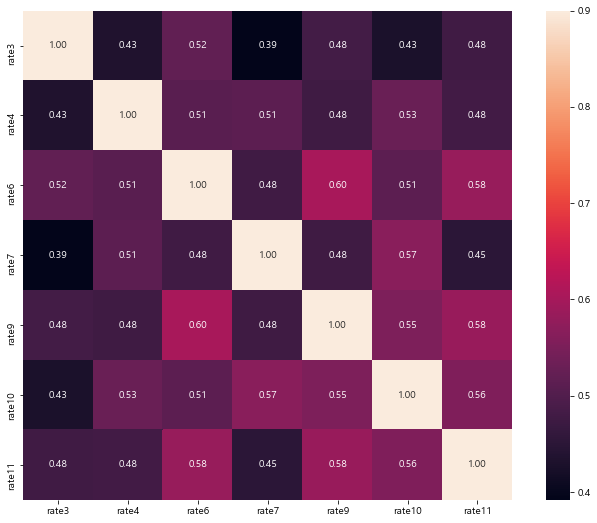

In [15]:
dtypes = data_mth.query("grd3<=3").dtypes
numerical_col = list(dtypes[(dtypes=='int64') | (dtypes=='float64')].index)
plt.subplots(figsize=(12,9))
sns.heatmap(data_mth.query("grd3<=3")[['rate3','rate4','rate6','rate7','rate9','rate10','rate11']].corr(),annot=True, fmt = ".2f", vmax=0.9, square=True)

### 회원 별 로우 데이터 변수 간 상관계수 그래프
1에 가까울 수록 값이 커지면 두 변수가 같이 데이터가 커지는 관계이며 (양의 관계)  
-1 에 가까울 수록 하나가 값이 커지면 다른 하나는 오히려 감소하는 관계 (음의 관계)

0에 가까울 수록 관련성이 없다고 판단 할 수 있음

위에서 매칭한 과거 차수와와 분석 대상 차수 간 원점수의 경우 상관계수가 0.71, 등급의 경우 0.72로 강한 상관관계가 확인됨. 

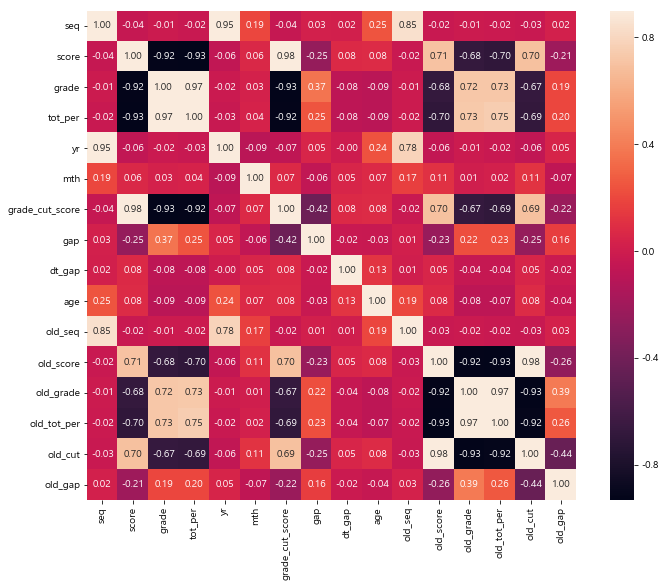

In [16]:
dtypes = dataset.dtypes
numerical_col = list(dtypes[(dtypes=='int64') | (dtypes=='float64')].index)
plt.subplots(figsize=(12,9))
sns.heatmap(dataset[numerical_col].corr(),annot=True, fmt = ".2f", vmax=0.9, square=True)
#

### 이전 등급기준 월별 시험의 등급 분포 그래프 (이전 등급 3등급 이상)
6월과 수능을 제외한 다른 시험에서는 이전에 받은 회원 성적 등급을 유지하는 경향이 보이지만,  
6월과 수능에서는 2등급 인원이 3등급으로 떨어지는 경우가 많은데 이는 6월에 재수생이 유입되면서 생기는 현상으로 판단됨.  
또한 수능에서는 2등급 인원이 다른 등급으로 이동하는 경우도 빈번 한 것으로 판단되며 월에 따른 플래그값을 모델에 이용하는게 유의하다고 판단됨

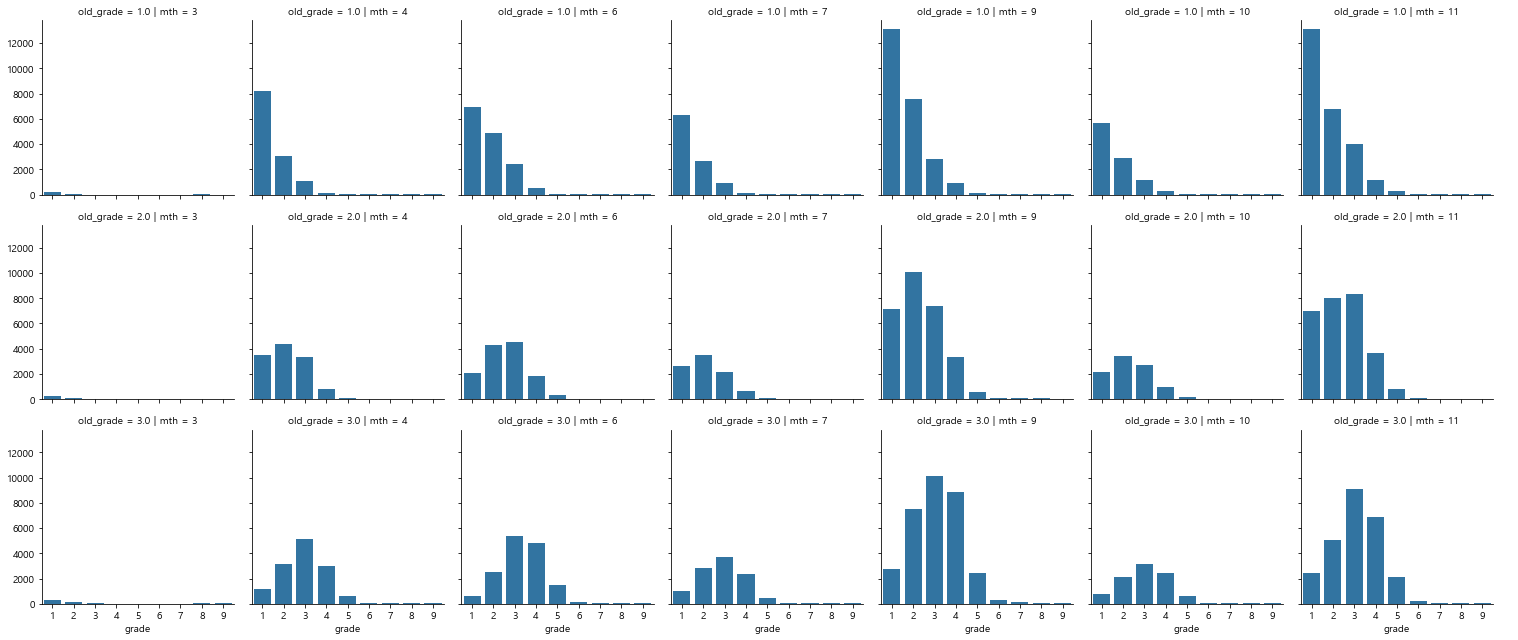

In [17]:
grid = sns.FacetGrid(dataset.query('old_grade<=3'), col='mth',row='old_grade')
grid.map(sns.countplot, 'grade')
grid.add_legend();

### 과거 등급별 원점수 일분위/중간값에 따른 등급컷

일분위 : 이전 시험에서 n등급을 받은 총 100명의 학생을 성적이 낮은 순 정렬 했을 때, **25등의 점수**  
중간값 : 이전 시험에서 n등급을 받은 총 100명의 학생을 성적이 낮은 순 정렬 했을 때, **50등의 점수**


일분위와 중간값을 쓰는 이유는 가짜로 데이터를 입력한 회원이 많은 관계로 평균값을 쓰게 된다면 통계량이 급격하게 증가 될 것이 우려되는 관계로 회원 분포 내 위치에 따른 통계량을 쓰는 것이 옳다고 판단됨

아래는 시험 차수, 과목코드, 이전 등급, 시험 채점시간을 기준으로 집계한 해당 시험의 원점수 일분위, 중간값과 해당 차수의 등급컷 간의 그래프이다.



- 과거 등급 기준 일분위 값과 등급컷 간 상관 그래프 - 채점 시간대 별

In [18]:
def reshape_dt_bin(dataset,df_grdcut,func,cut_grade,cols=['seq','sub_cod','old_grade','mth','score','old_score','dt_bin','grade_cut_score']):
    dataset_subset=pd.DataFrame()

    for i in labels:
        tmp = eval("dataset.query('dt_bin<={0}').groupby(['seq','sub_cod','old_grade','mth']).{1}[['score','old_score']].reset_index()".format(i,func))
        tmp['dt_bin']=i
        dataset_subset=pd.concat([dataset_subset,tmp]) if dataset_subset.size else tmp

    dataset_subset=pd.merge(dataset_subset,df_grdcut,left_on=['seq','sub_cod','old_grade'],right_on=['seq','sub_cod','grade'])
    dataset_subset=dataset_subset.query("grade<=%d"%cut_grade)
    return dataset_subset[cols]

In [19]:
dataset_subset = reshape_dt_bin(dataset,df_grdcut,'quantile(0.25)',3)

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


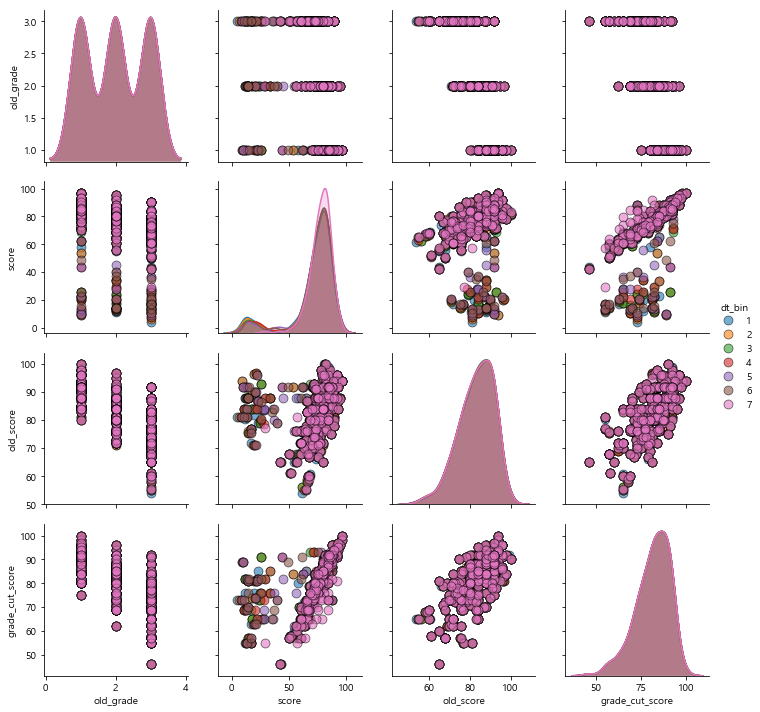

In [20]:
sns.pairplot(dataset_subset,vars = ['old_grade','score','old_score','grade_cut_score'],hue='dt_bin',  plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

- 과거 등급 기준 일분위 값과 등급컷 간 상관 그래프  - 현재 등급별

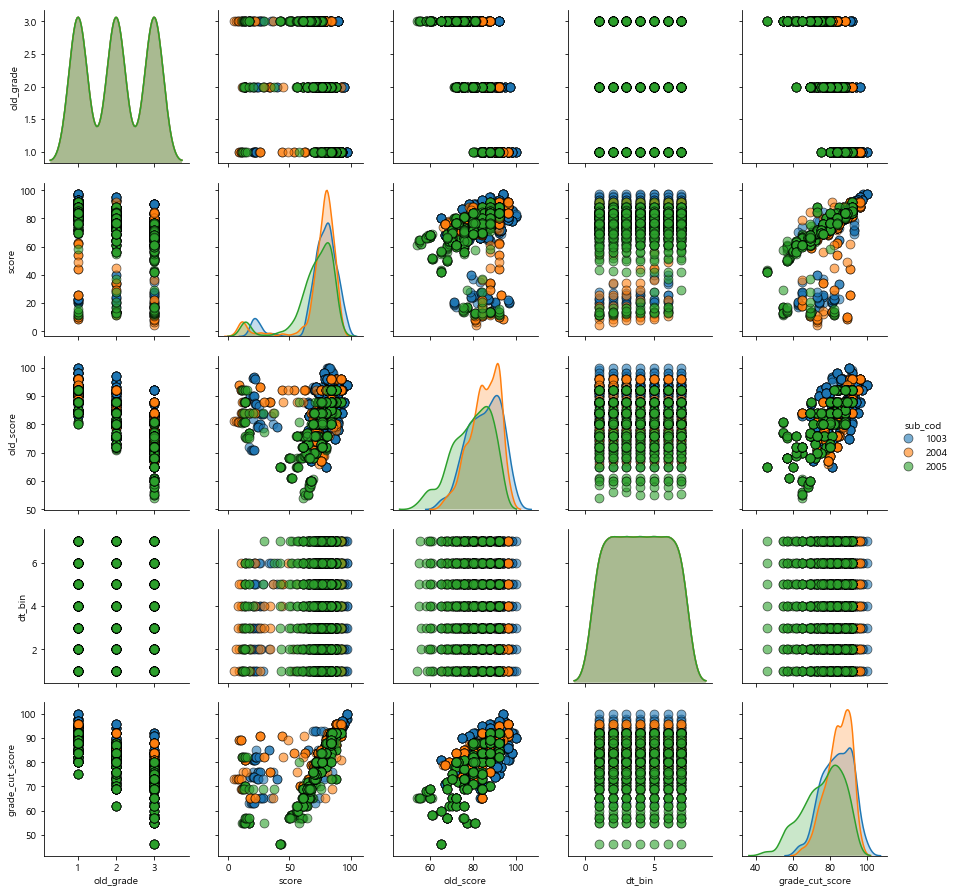

In [21]:
sns.pairplot(dataset_subset,vars = ['old_grade','score','old_score','dt_bin','grade_cut_score'],hue='sub_cod',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

### 현재 집계된 데이터 중 과거 점수와 현재 점수가 급격하게 떨어지는 구간이 있는것이 확인, 월 단위로 한번 확인

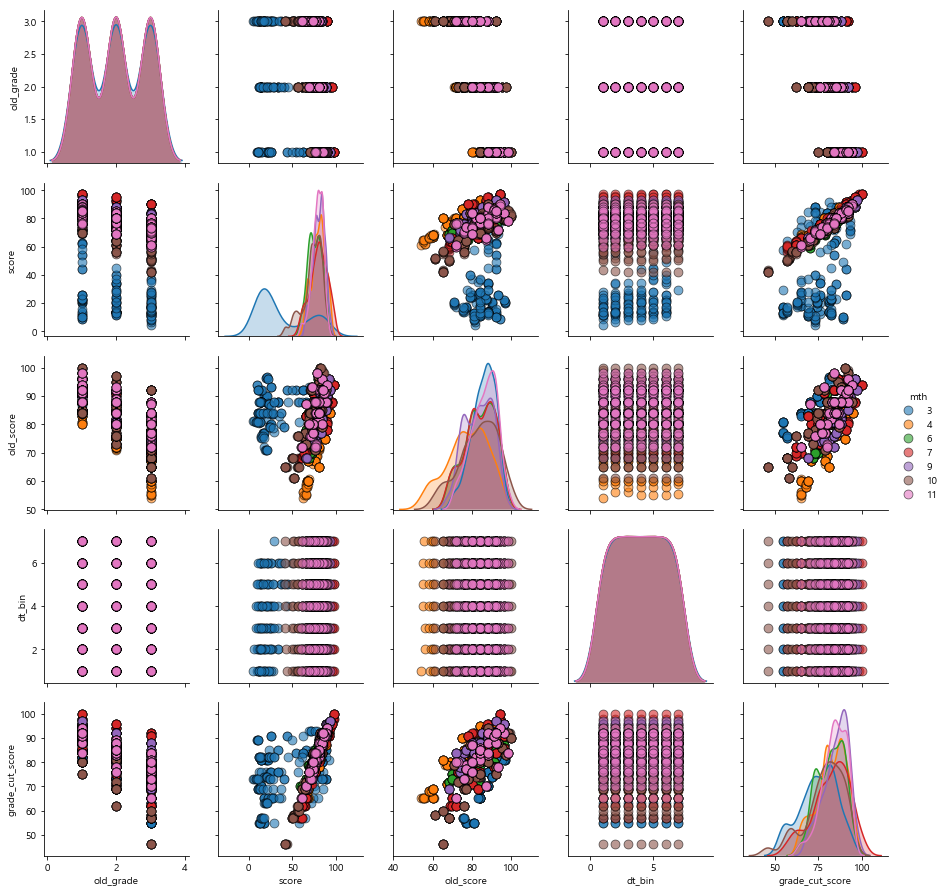

In [22]:
sns.pairplot(dataset_subset,vars = ['old_grade','score','old_score','dt_bin','grade_cut_score'],hue='mth',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

3월 데이터가 문제인 것을 확인하여 3월 데이터를 제외하고 다시 그려본 결과 현재 집계된 데이터와 등급컷 사이 명확한 상관관계가 보이는 것을 확인 할 수 있음.

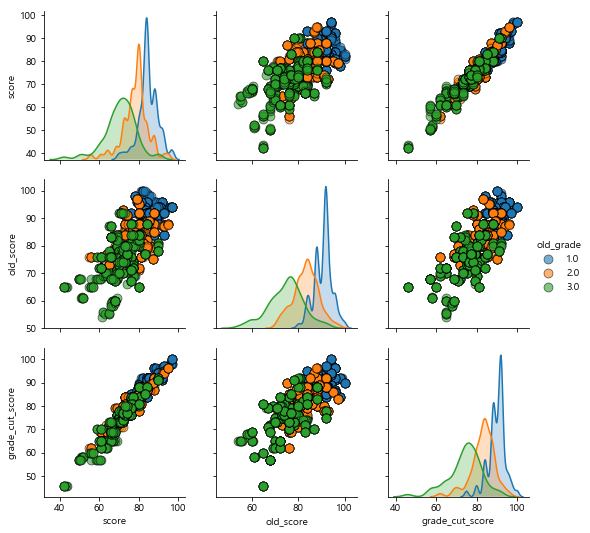

In [23]:
dataset_subset=dataset_subset.query("mth!=3")
sns.pairplot(dataset_subset,vars = ['score','old_score','grade_cut_score'],hue='old_grade',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

In [24]:
dataset_subset2 = reshape_dt_bin(dataset,df_grdcut,'quantile(0.5)',3)
dataset_subset2=dataset_subset2.query("mth!=3")

In [25]:
dataset_subset2.head()

,seq,sub_cod,old_grade,mth,score,old_score,dt_bin,grade_cut_score
0,187,1003,1.000,4,94.500,93.000,1,93
1,187,1003,1.000,4,94.000,93.000,2,93
2,187,1003,1.000,4,94.000,93.000,3,93
3,187,1003,1.000,4,94.000,93.000,4,93
4,187,1003,1.000,4,94.000,93.000,5,93


### score_x, old_score_x -> 일분위 값  score_y,old_score_y -> 중간값
등급컷과 현재 일분위, 중간값 그리고 과거 일분위, 중간값 데이터 간 상관계수 데이터 확인

In [26]:
dataset_subset_final = pd.merge(dataset_subset,dataset_subset2,on=['seq', 'sub_cod', 'old_grade', 'mth','dt_bin','grade_cut_score'])
                             

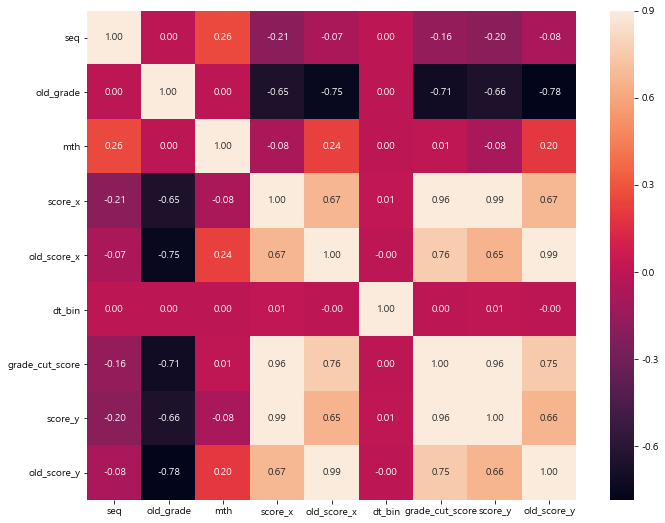

In [27]:
dtypes = dataset_subset_final.dtypes
numerical_col = list(dtypes[(dtypes=='int64') | (dtypes=='float64')].index)
plt.subplots(figsize=(12,9))
sns.heatmap(dataset_subset_final[numerical_col].corr(),annot=True, fmt = ".2f", vmax=0.9, square=True)

## 이전 시험에서 원점수가 등급컷에 걸린 인원 통계확인하기 - 중간값 기준
이전 시험의 원점수가 등급컷과 동일한 회원의 분포가 등급컷에 얼마나 큰 영향을 미치는지 확인하고자 함.   
pairplot을 통해 상관관계를 확인해본 결과, 어느 정도 유의한 분포가 보이지만 추세에서 벗어나 튀는 값들이 확인됨.   
등급컷과 동일한 원점수를 받은 인원의 수가 적은 것도 문제지만 이전의 등급컷이 평소에 자주 나오지 않는 등급컷인 경우 더욱 적은 인원이 조건에 해당되기 때문에 데이터에 노이즈가 생긴 것이 확인됨.


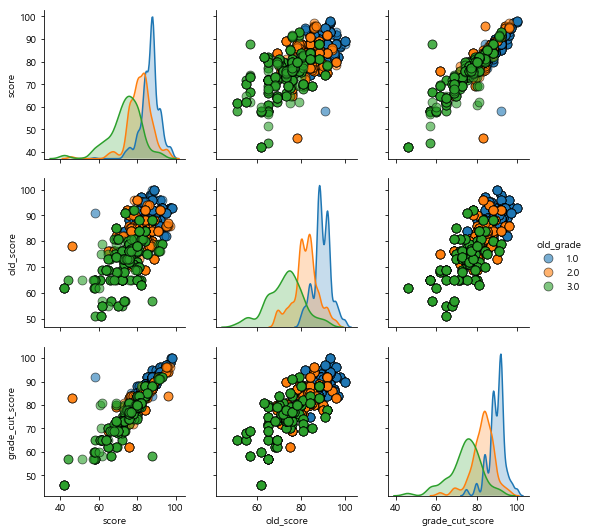

In [28]:
dataset_cut = reshape_dt_bin(dataset.query('(mth!=3) &(old_cut==old_score)'),df_grdcut,'median()',3)
sns.pairplot(dataset_cut,vars = ['score','old_score','grade_cut_score'],hue='old_grade',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

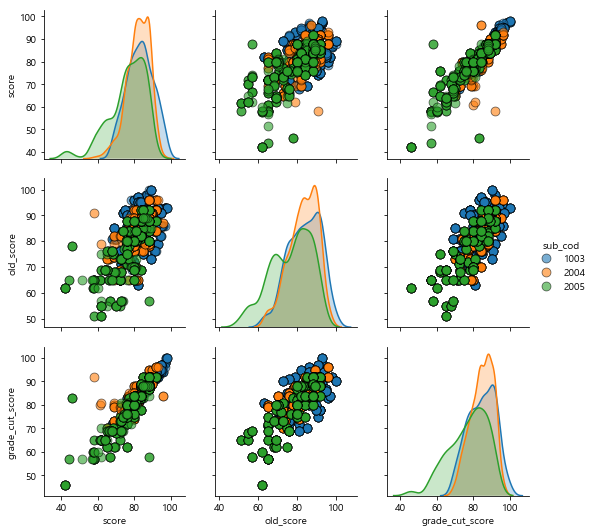

In [29]:
sns.pairplot(dataset_cut,vars = ['score','old_score','grade_cut_score'],hue='sub_cod',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

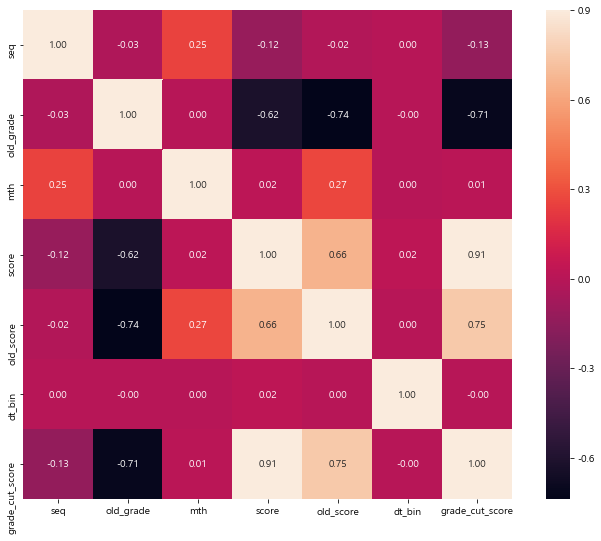

In [30]:
dtypes = dataset_cut.dtypes
numerical_col = list(dtypes[(dtypes=='int64') | (dtypes=='float64')].index)
plt.subplots(figsize=(12,9))
sns.heatmap(dataset_cut[numerical_col].corr(),annot=True, fmt = ".2f", vmax=0.9, square=True)

#### 확인한 결과 등급컷과 집계된 중간값 간에 오차가 튀는 부분이 있어 확인한 결과 이전 시험 등급컷에 걸린 인원이 너무 적어 발생한 결과로 확인

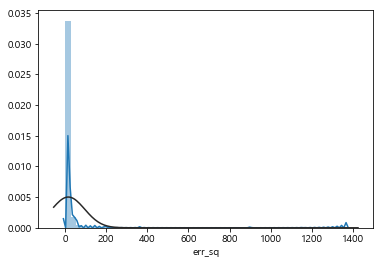

In [31]:
dataset_cut['err_sq']=(dataset_cut['grade_cut_score']-dataset_cut['score'])**2
sns.distplot(dataset_cut['err_sq'], fit=norm)

In [32]:
dataset_subset_final['err_sq']=(dataset_subset_final['grade_cut_score']-dataset_subset_final['score_y'])**2
dataset_subset_final['err_sq25']=(dataset_subset_final['grade_cut_score']-dataset_subset_final['score_x'])**2
dataset_subset_final.describe()

,seq,old_grade,mth,score_x,old_score_x,dt_bin,grade_cut_score,score_y,old_score_y,err_sq,err_sq25
count,1512.000,1512.000,1512.000,1512.000,1512.000,1512.000,1512.000,1512.000,1512.000,1512.000,1512.000
mean,228.875,2.000,7.833,77.977,83.031,4.000,82.477,83.660,85.063,9.299,26.606
std,20.613,0.817,2.410,8.786,8.630,2.001,8.938,7.596,8.178,17.192,24.427
min,187.000,1.000,4.000,42.000,54.000,1.000,46.000,52.000,59.000,0.000,0.000
25%,216.000,1.000,6.000,73.000,77.000,2.000,77.000,80.000,80.000,0.000,9.000
50%,231.000,2.000,8.000,80.000,84.000,4.000,84.000,84.000,86.000,4.000,16.000
75%,245.000,3.000,10.000,84.000,90.000,6.000,89.000,88.000,92.000,16.000,36.000
max,259.000,3.000,11.000,97.000,100.000,7.000,100.000,98.000,100.000,144.000,121.000


In [33]:
dataset_cut_cnt= reshape_dt_bin(dataset.query('(mth!=3) &(old_cut==old_score)'),df_grdcut,'count()',3)
dataset_cut_cnt = dataset_cut_cnt[['seq','sub_cod','old_grade','dt_bin','old_score']]
dataset_cut_cnt.columns=['seq','sub_cod','old_grade','dt_bin','cnt']

dataset_cut_cnt=pd.merge(dataset_cut,dataset_cut_cnt,how='inner',on=['seq','sub_cod','old_grade','dt_bin'])
print("이전 등급컷 대상자 중 들어온 인원 10명 미만인 비율 : ",len(dataset_cut_cnt[dataset_cut_cnt['cnt']<10])/len(dataset_cut_cnt)*100,'%')

이전 등급컷 대상자 중 들어온 인원 10명 미만인 비율 :  9.471516815374056 %


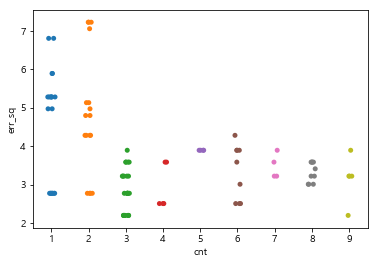

In [34]:
dataset_cut_cnt['err_sq']=dataset_cut_cnt['err_sq'].map(lambda x: np.log(x) if x!=0 else 0)
sns.stripplot(x='cnt',y='err_sq',data=dataset_cut_cnt.query("(err_sq>2)&(cnt<10)"))

### **이전 등급컷에 걸린 인원이 2명 이하인 경우 오류 급격하게 증가** - 그냥 중간값을 쓰는게 분산, 오류 면에서 이득 
#### 사용하지 않기로 결정

해당 차수에 채점한 인원 중 이전 시험의 등급별 비율을 데이터에 추가하여 유의한지 확인하기로 함.
차수, 과목코드, 채점한 시간에 따라 groupby 

In [35]:

dataset_not3=dataset.query("mth!=3")
dataset_cross=pd.crosstab([dataset_not3['seq'],dataset_not3['sub_cod'],dataset_not3['dt_bin']],dataset_not3['old_grade'])

dataset_subset_tmp=pd.DataFrame()

for i in [1,2,3,4,5,6,7]:
    tmp = dataset_cross.query('dt_bin<={0}'.format(i)).groupby(['seq','sub_cod']).sum().reset_index()
    tmp['dt_bin'] = i
    dataset_subset_tmp=pd.concat([dataset_subset_tmp,tmp]) if dataset_subset.size else tmp

dataset_subset_tmp.set_index(['seq','sub_cod','dt_bin'])

dataset_cross = dataset_cross
dataset_cross=dataset_cross.apply(lambda x: x/np.sum(x),axis=1)
dataset_cross=dataset_cross[[1,2,3]]

dataset_cross.columns=['old_ratio_1','old_ratio_2','old_ratio_3']
dataset_cross=dataset_cross.reset_index()


In [36]:
dataset_subset_final.dt_bin=pd.Categorical(dataset_subset_final.dt_bin)
dataset_cross_mer=pd.merge(dataset_subset_final,dataset_cross,how='inner',on=['seq','sub_cod','dt_bin'])


In [37]:
dataset_cross_mer=dataset_cross_mer.rename({'score_x':'now_q1_score','score_y':'now_med_score','old_score_x':'old_q1_score','old_score_y':'old_med_score'},axis=1)
dataset_cross_mer=dataset_cross_mer.drop_duplicates()

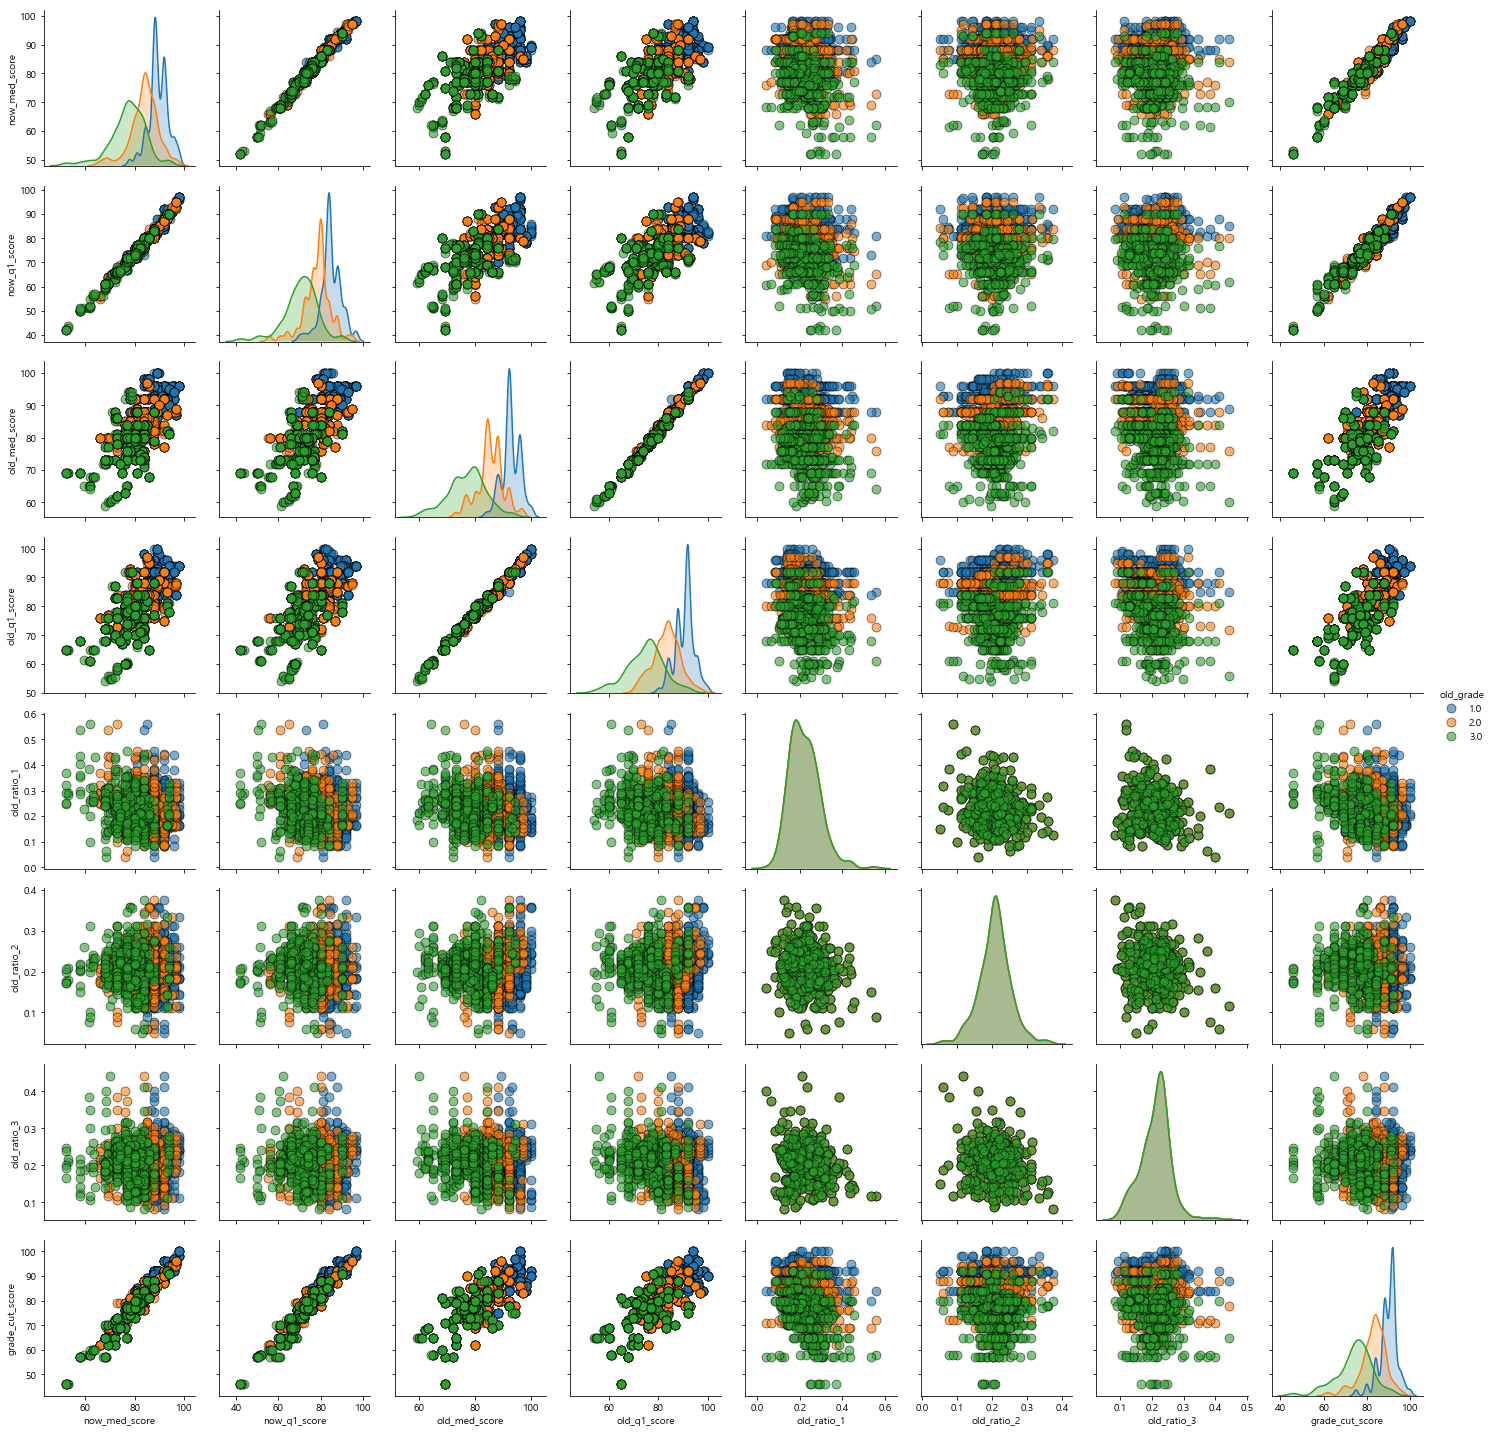

In [38]:
sns.pairplot(dataset_cross_mer,vars = ['now_med_score','now_q1_score','old_med_score','old_q1_score','old_ratio_1','old_ratio_2','old_ratio_3','grade_cut_score'],hue='old_grade',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

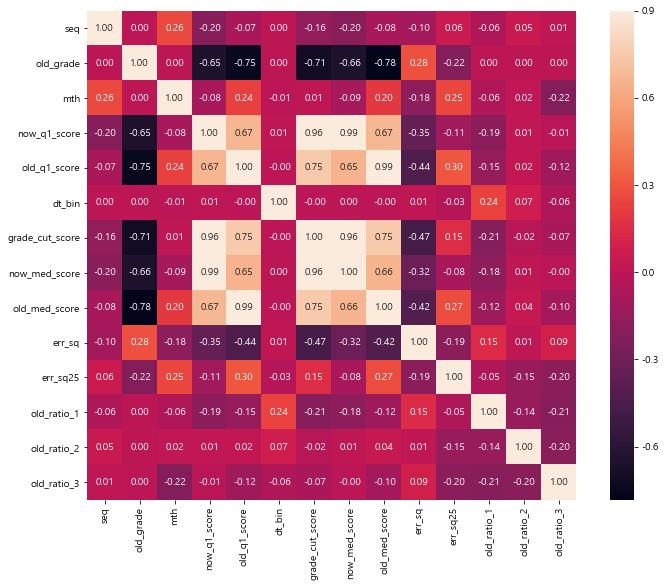

In [39]:
dtypes = dataset_cross_mer.dtypes
numerical_col = list(dtypes[(dtypes=='int64') | (dtypes=='float64')].index)
plt.subplots(figsize=(12,9))
sns.heatmap(dataset_cross_mer[numerical_col].corr(),annot=True, fmt = ".2f", vmax=0.9, square=True)

## 전처리 이후 집계 데이터
### 최종 데이터는 위에서 활용하기한 변수를 정리하여 하나의 로우로 만든다.

현재 old_grade 기준으로 쌓인 데이터를 로우 단위로 변환시켜 준다.

또한, 과목코드, 등급, 월 정보, 시간 등 변수를 아무런 변환 없이 머신러닝 모델에 입력할 경우 앞의 데이터 형태를 모델이 코드가 아닌 숫자로 인식하여 모델을 생성하는 관계로 0과 1로 구분하는 플래그 값으로 데이터를 변환 시켜준다.


In [40]:
dataset_cross_mer=dataset_cross_mer.drop(['err_sq','err_sq25'],axis=1)

In [41]:
dataset_cross_mer_pivot=dataset_cross_mer.drop('grade_cut_score',axis=1).set_index(['seq','sub_cod','mth','dt_bin','old_grade','old_ratio_1','old_ratio_2','old_ratio_3']).unstack(level='old_grade').fillna(0)

In [42]:
col_nm=list(dataset_cross_mer_pivot.index.names)
for i,j in dataset_cross_mer_pivot.columns:
    col_nm.append('{0}_{1}'.format(i,int(j)))

In [43]:
dataset_cross_mer_pivot=dataset_cross_mer_pivot.reset_index()
dataset_cross_mer_pivot.columns=col_nm
dataset_cross_mer_pivot=pd.merge(dataset_cross_mer_pivot,df_grdcut.loc[df_grdcut['grade']<=3,['seq','sub_cod','score','grade','grade_cut_score']],on=['seq','sub_cod'])
#dataset_cross_mer_pivot=dataset_cross_mer_pivot.drop(['seq','sub_cod'],axis=1)


In [44]:
dataset_cross_mer_pivot=pd.get_dummies(dataset_cross_mer_pivot, columns = ["mth"],prefix='mth')
dataset_cross_mer_pivot=pd.get_dummies(dataset_cross_mer_pivot, columns = ["dt_bin"],prefix='dt')
dataset_cross_mer_pivot=pd.get_dummies(dataset_cross_mer_pivot, columns = ["sub_cod"],prefix='sub')
dataset_cross_mer_pivot=pd.get_dummies(dataset_cross_mer_pivot, columns = ["grade"],prefix='grd')

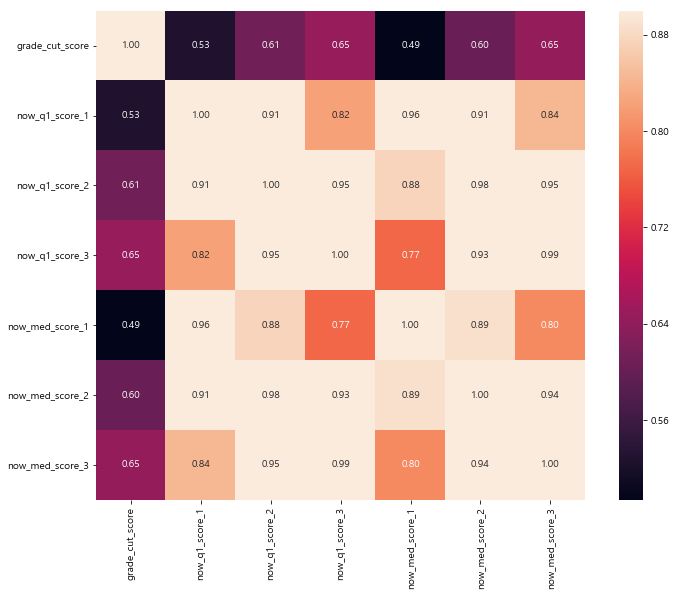

In [45]:
vars = ['grade_cut_score','now_q1_score_1', 'now_q1_score_2', 'now_q1_score_3', 'now_med_score_1', 'now_med_score_2', 'now_med_score_3']
plt.subplots(figsize=(12,9))
sns.heatmap(dataset_cross_mer_pivot[vars].corr(),annot=True, fmt = ".2f", vmax=0.9, square=True)

## 최종 사용 데이터 

## 3. 모델링 시작
- **train, test data split의 경우 시험차수를 기준으로 7:3 비율로 split**  
이유는 한 차수당 시간에 대한 변수 dt_n 이 있는 관계로 그냥 split 하게 되면 test dataset에 있는 비슷한 데이터가 train되어 test 결과가 과대
추정되는 문제가 발생한다. 또한 하나의 시험에 데이터가 시간대 별로 집계된 상태임으로 교차검증 시 시험 차수 기준으로 group 한 다음 k-fold 검정을 시도해야함.(GroupKFold 함수 import)   

- **바로 직전 차수에 대한 시험 성적 데이터 사용X**  
위의 heatmap에서 상관계수를 확인한 결과, 데이터가 유의하지 않다고 판단되며 직관적으로 생각해봤을때 시험 간 난이도 널뛰기가 빈번한 관계로 제외한 다음 모델링을 하는게 유리하다고 판단하여 제외.

- **데이터 정보**

| 칼럼 | 칼럼명 | 비고 |
|:---|:---:|:---:|
| `now_q1_score_X` | 이전 대상 시험 X등급인 인원의 25% 지점의 원점수||
| `now_med_score_X` | 이전 대상 시험 X등급인 인원의 50% 지점의 원점수||
| `mth_X` | 시험 X월 플래그 | 해당 시험이 X월인 경우 1 아닌 경우 0 | 
| `dt_X` | 시간 플래그 | dt_bin 데이터 설명 참조 |
| `sub_X` | 과목코드 플래그 | sub_1003: 국어, sub_2004: 수학가 sub_2005: 수학나 |
| `grd_X` | 등급 플래그 | 추정하고자 하는 등급에 해당 할 경우 1 아니면 0 |


In [68]:
#split train, test datasets
from sklearn.model_selection import GroupKFold, KFold, cross_val_score, train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import metrics
import random as rd
from sklearn.svm import SVC, SVR
col_x = [i for i in dataset_cross_mer_pivot.columns if i not in ['grade_cut_score','seq','old_med_score_1','old_med_score_2','old_med_score_3'
                                                         ,'old_q1_score_1','old_q1_score_2','old_q1_score_3',,'score']]

seq = dataset_cross_mer_pivot['seq'].unique().tolist()
train_seq = rd.sample(seq,int(len(seq)*0.7))

train = dataset_cross_mer_pivot[dataset_cross_mer_pivot['seq'].isin(train_seq)]
test = dataset_cross_mer_pivot[~dataset_cross_mer_pivot['seq'].isin(train_seq)]

X_train, y_train = train[col_x], train['grade_cut_score']
X_test, y_test = test[col_x], test['grade_cut_score']

In [75]:
def rmsle_cv(model):
    group_kfold = GroupKFold(n_splits=5)
    kf = group_kfold.split(X_train, y_train, groups=train['seq'])
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

사용할 모델은 XGBOOST, lasso 회귀모형, ENET 회귀모형, Kernel lasso 회귀모형, Gradient Boosting, Light Gradient Boosting 사용  
바로 아래는 XGBOOST 결과와 가장 유의하게 판단되는 변수에 대한 설명

#### 회귀분석 모형에 대한 판단은 오차의 제곱의 평균(MSE) 를 기준으로 판단하며 낮을 수록 오차가 적다는 것을 나타낸다.

Start Training
XGBRegressor: 2.1519 (0.6544)

Start Predicting
MSE : 5.702


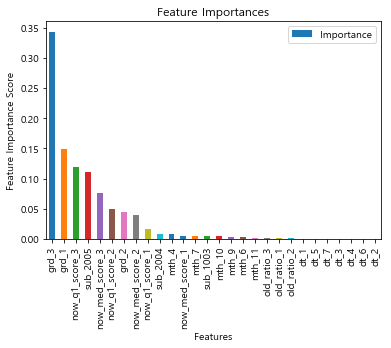

In [74]:
n_folds=5
"""
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.55, gamma=0.05, 
                             learning_rate=0.01, max_depth=3, 
                             min_child_weight=7.5, n_estimators=2200,
                             reg_alpha=0.35, reg_lambda=0.45,
                             subsample=0.55, silent=1,
                             random_state =7, nthread = -1)

"""
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.55, gamma=0.05, 
                             learning_rate=0.01, max_depth=3, 
                             min_child_weight=7.5, n_estimators=2200,
                             reg_alpha=0.35, reg_lambda=0.45,
                             subsample=0.55, silent=1,
                             random_state =7, nthread = -1)

# training 시작
print('Start Training')
xgb_reg.fit(X_train, y_train)

score=rmsle_cv(xgb_reg)


print("XGBRegressor: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

# predicting 시작
print("Start Predicting")
predictions_xgb = xgb_reg.predict(X_test)



print("MSE : %.4g" % metrics.mean_squared_error(y_test, predictions_xgb))

feat_imp = xgb_reg.feature_importances_
feat = X_train.columns.tolist()
# clf.best_estimator_.booster().get_fscore()
res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()


In [71]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import lightgbm as lgb

categoric=['mth_4','mth_6','mth_7','mth_9','mth_10','mth_11','dt_1','dt_2','dt_3','dt_4','dt_5','dt_6','dt_7','sub_1003','sub_2004','sub_2005','grd_1','grd_2','grd_3'
]

lasso = Lasso(alpha =0.01, random_state=1)
ENet = ElasticNet(alpha=0.01, l1_ratio=.53, random_state=3)
KRR = KernelRidge(alpha=1.27, kernel='polynomial', degree=2, coef0=0.025)#2
lgbr = lgb.LGBMRegressor(objective='regression',
                              learning_rate=0.07, n_estimators=3000,max_depth=4,
                              num_boost_round=10000,
                              max_bin = 20, bagging_fraction = 0.83,
                              bagging_freq = 7, feature_fraction = 0.15,metric='mse',
                              boosting='dart',
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =2, min_sum_hessian_in_leaf = 8,save_binary=True)

"""
lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.02, n_estimators=2200,
                              num_boost_round=500,
                              max_bin = 55, bagging_fraction = 0.7,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,save_binary=True)

"""
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)


tmp=pd.DataFrame()
tmp['seq']=test.seq
tmp['grade_cut_score']=y_test
for clf, label in zip([xgb_reg, lasso, ENet, KRR,lgbr,GBoost], 
                      ['XGB', 
                       'lasso', 
                       'ENET',
                       'KRR','LGB','GBT']):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    print("{} MSE : {:.4f}".format(label, metrics.mean_squared_error(y_test,predictions)))
    tmp[label]= predictions



XGB MSE : 5.7022
lasso MSE : 5.6525
ENET MSE : 5.6605
KRR MSE : 2.5809
LGB MSE : 6.6079
GBT MSE : 5.9388


위의 모델을 토대로 가장 약하게 분류되는 3개의 모델 (xgboost, GradientBoosting, KRR)를 이용하여 하나의 Stacking 모형을 생성한다.

![참조][logo]

[logo]: http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor_files/stackingregression_overview.png "stacking."



In [73]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression


lr = Lasso(alpha=0.05, random_state=3)
#lr=LinearRegression()
regs = [lgbr,GBoost,KRR]
stregr = StackingRegressor(regressors=regs, meta_regressor=lr)
#stregr = StackingRegressor(regressors=regs, meta_regressor=xgb_reg)


stregr.fit(X_train, y_train)

score=rmsle_cv(stregr)
print("\nmeta score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
meta_pred = stregr.predict(X_test)

print("meta MSE : %.4g" % metrics.mean_squared_error(y_test, meta_pred ))

tmp['meta_pre']= meta_pred



meta score: 2.1302 (0.7997)

meta MSE : 6.41


## 4. 결론

과거 시험에 응시한 인원의 성적을 토대로 현재의 등급컷을 추정하는 여러가지 모델을 생성했으며, 그 중 가장 퍼포먼스가 좋았던 3개의 모델을 이용하여 Stacking 모델을 생성 완료했다.
결과는 Kernel Ridge Regression 모델이 Test결과 MSE가 2.5809로 다른 모델이 보여준 5~6 사이의 MSE보다 압도적으로 작게 나온 것을 확인했다.

해당 모델을 생성하는데 있어 3월 학력평가 데이터는 변수로 활용하는데 이상값으로 분류되는 경향이 강해 제외하고 모델링을 한 관계로, 현재 모델은 3월 학력평가 등급컷을 추정하는데 있어 적합하지 못하다는 단점이 있다.
따라서 향후 해당 모델을 사용하는데 있어 3월 학력평가에도 활용이 가능하도록 개선하는 방향이 최우선시 되야 한다고 판단됨.


